In [3]:
# If running in Google Colab, import files
try:
    import google.colab
    in_colab = True
except:
    in_colab = False

if in_colab:
    !git clone https://github.com/ahojszyk/OnePixelAttackCIFAR10.git

fatal: destination path 'OnePixelAttackCIFAR10' already exists and is not an empty directory.


In [4]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import clear_output
from tensorflow.keras.datasets import cifar10
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import LearningRateScheduler, TensorBoard, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D, Dropout, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import json
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix
import time

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [28]:

class Net:
    """
    A class representing various CNN architectures for CIFAR-10.
    Includes training, evaluation, prediction, and visualization capabilities.
    """

    def __init__(self, epochs=200, batch_size=128, load_weights=True, net_type='LeNet'):

        """
        Initialize the network with the specified parameters.

        Args:
            epochs (int): Number of training epochs.
            batch_size (int): Batch size for training.
            load_weights (bool): Whether to load pre-trained weights if available.
            net_type (str): The type of network architecture to use.
        """

        self.name = net_type
        self.model_filename = f'OnePixelAttackCIFAR10/networks/models/{net_type}.keras'
        self.checkpoint_filepath = f'OnePixelAttackCIFAR10/networks/models/{net_type}_checkpoint.keras'
        self.num_classes = 10
        self.input_shape = (32, 32, 3)
        self.batch_size = batch_size
        self.epochs = epochs
        self.weight_decay = 0.0001
        self.log_filepath = f'OnePixelAttackCIFAR10/networks/models/{net_type}'

        if load_weights:
            try:
                self._model = load_model(self.model_filename)
                print('Successfully loaded', self.name)
            except (ImportError, ValueError, OSError):
                print('Failed to load', self.name)

    def count_params(self):
        """
        Return the number of trainable parameters in the model.

        Returns:
            int: Number of trainable parameters.
        """
        return self._model.count_params()

    def color_preprocessing(self, x_train, x_test):

        """
        Normalize image data for training and testing.

        Args:
            x_train (np.array): Training images.
            x_test (np.array): Testing images.

        Returns:
            Tuple[np.array, np.array]: Preprocessed training and testing images.
        """

        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        mean = [125.307, 122.95, 113.865]
        std  = [62.9932, 62.0887, 66.7048]
        for i in range(3):
            x_train[:,:,:,i] = (x_train[:,:,:,i] - mean[i]) / std[i]
            x_test[:,:,:,i] = (x_test[:,:,:,i] - mean[i]) / std[i]
        return x_train, x_test

    def build_model(self):

        """
        Build the model based on the specified network type.

        Returns:
            keras.Model: Compiled model.
        """

        if self.name == 'LeNet':
            model = Sequential()
            model.add(Conv2D(6, kernel_size=5, strides=1,  activation='relu', input_shape=(32,32,3), padding='same'))
            model.add(AveragePooling2D(pool_size=2, strides = 2))
            model.add(Conv2D(16, kernel_size=5, strides=1, activation='relu', padding='valid'))
            model.add(AveragePooling2D(pool_size=2, strides = 2))
            model.add(Conv2D(120, kernel_size=5, strides=1, activation='relu', padding='valid'))
            model.add(Flatten())
            model.add(Dense(84, activation='relu'))
            model.add(Dense(10, activation='softmax'))

        elif self.name == 'All Convolution':
            model = Sequential()
            model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same', input_shape=(32,32,3)))
            model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same'))
            model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same', strides = 2))
            model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same'))
            model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same'))

            model.add(Dropout(0.3))

            model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same', strides = 2))
            model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same', strides = 2))
            model.add(Conv2D(192, (1, 1), activation='relu', padding='valid'))
            model.add(Conv2D(10, (1, 1), activation='relu', padding='valid'))

            model.add(GlobalAveragePooling2D())
            model.add(Activation('softmax'))

        elif self.name == 'VGG16':
            model = Sequential()
            model.add(Conv2D(64, (3, 3), padding='same',
                         input_shape=(32,32,3),kernel_regularizer=l2(self.weight_decay)))
            model.add(Activation('relu'))
            model.add(BatchNormalization())
            model.add(Dropout(0.3))

            model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=l2(self.weight_decay)))
            model.add(Activation('relu'))
            model.add(BatchNormalization())

            model.add(MaxPooling2D(pool_size=(2, 2)))

            model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=l2(self.weight_decay)))
            model.add(Activation('relu'))
            model.add(BatchNormalization())
            model.add(Dropout(0.4))

            model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=l2(self.weight_decay)))
            model.add(Activation('relu'))
            model.add(BatchNormalization())

            model.add(MaxPooling2D(pool_size=(2, 2)))

            model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=l2(self.weight_decay)))
            model.add(Activation('relu'))
            model.add(BatchNormalization())
            model.add(Dropout(0.4))

            model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=l2(self.weight_decay)))
            model.add(Activation('relu'))
            model.add(BatchNormalization())
            model.add(Dropout(0.4))

            model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=l2(self.weight_decay)))
            model.add(Activation('relu'))
            model.add(BatchNormalization())

            model.add(MaxPooling2D(pool_size=(2, 2)))


            model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=l2(self.weight_decay)))
            model.add(Activation('relu'))
            model.add(BatchNormalization())
            model.add(Dropout(0.4))

            model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=l2(self.weight_decay)))
            model.add(Activation('relu'))
            model.add(BatchNormalization())
            model.add(Dropout(0.4))

            model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=l2(self.weight_decay)))
            model.add(Activation('relu'))
            model.add(BatchNormalization())

            model.add(MaxPooling2D(pool_size=(2, 2)))


            model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=l2(self.weight_decay)))
            model.add(Activation('relu'))
            model.add(BatchNormalization())
            model.add(Dropout(0.4))

            model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=l2(self.weight_decay)))
            model.add(Activation('relu'))
            model.add(BatchNormalization())
            model.add(Dropout(0.4))

            model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=l2(self.weight_decay)))
            model.add(Activation('relu'))
            model.add(BatchNormalization())

            model.add(MaxPooling2D(pool_size=(2, 2)))
            model.add(Dropout(0.5))

            model.add(Flatten())
            model.add(Dense(2048,kernel_regularizer=l2(self.weight_decay)))
            model.add(Activation('relu'))
            model.add(BatchNormalization())

            model.add(Dense(2048,kernel_regularizer=l2(self.weight_decay)))
            model.add(Activation('relu'))
            model.add(BatchNormalization())

            model.add(Dropout(0.5))
            model.add(Dense(self.num_classes))
            model.add(Activation('softmax'))

        elif self.name == 'VGG8':
            model = Sequential()
            model.add(Conv2D(128,(3,3), activation = 'relu', kernel_initializer = 'he_uniform', padding = 'same', input_shape = (32,32,3)))
            model.add(BatchNormalization())
            model.add(Conv2D(128,(3,3), activation = 'relu', kernel_initializer = 'he_uniform', padding = 'same'))
            model.add(BatchNormalization())
            model.add(MaxPooling2D((2,2)))
            model.add(Dropout(0.2))
            model.add(Conv2D(256,(3,3), activation = 'relu', kernel_initializer = 'he_uniform', padding = 'same'))
            model.add(BatchNormalization())
            model.add(Conv2D(256,(3,3), activation = 'relu', kernel_initializer = 'he_uniform', padding = 'same'))
            model.add(BatchNormalization())
            model.add(MaxPooling2D((2,2)))
            model.add(Dropout(0.3))
            model.add(Conv2D(512,(3,3), activation = 'relu', kernel_initializer = 'he_uniform', padding = 'same'))
            model.add(BatchNormalization())
            model.add(Conv2D(512,(3,3), activation = 'relu', kernel_initializer = 'he_uniform', padding = 'same'))
            model.add(BatchNormalization())
            model.add(MaxPooling2D((2,2)))
            model.add(Dropout(0.4))


            model.add(Flatten())
            model.add(Dense(8192, activation = 'relu', kernel_initializer = 'he_uniform'))
            model.add(BatchNormalization())
            model.add(Dense(1024, activation = 'relu', kernel_initializer = 'he_uniform'))
            model.add(Dropout(0.5))
            model.add(Dense(10, activation = 'softmax'))

        elif self.name == "Network in Network":
            model = Sequential()
            model.add(Conv2D(192, (5, 5), padding='same', kernel_regularizer=keras.regularizers.l2(self.weight_decay), kernel_initializer="he_normal", input_shape=self.input_shape))
            model.add(BatchNormalization())
            model.add(Activation('relu'))
            model.add(Conv2D(160, (1, 1), padding='same', kernel_regularizer=keras.regularizers.l2(self.weight_decay), kernel_initializer="he_normal"))
            model.add(BatchNormalization())
            model.add(Activation('relu'))
            model.add(Conv2D(96, (1, 1), padding='same', kernel_regularizer=keras.regularizers.l2(self.weight_decay), kernel_initializer="he_normal"))
            model.add(BatchNormalization())
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(3, 3),strides=(2,2),padding = 'same'))

            model.add(Dropout(0.5))

            model.add(Conv2D(192, (5, 5), padding='same', kernel_regularizer=keras.regularizers.l2(self.weight_decay), kernel_initializer="he_normal"))
            model.add(BatchNormalization())
            model.add(Activation('relu'))
            model.add(Conv2D(192, (1, 1),padding='same', kernel_regularizer=keras.regularizers.l2(self.weight_decay), kernel_initializer="he_normal"))
            model.add(BatchNormalization())
            model.add(Activation('relu'))
            model.add(Conv2D(192, (1, 1),padding='same', kernel_regularizer=keras.regularizers.l2(self.weight_decay), kernel_initializer="he_normal"))
            model.add(BatchNormalization())
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(3, 3),strides=(2,2),padding = 'same'))

            model.add(Dropout(0.5))

            model.add(Conv2D(192, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(self.weight_decay), kernel_initializer="he_normal"))
            model.add(BatchNormalization())
            model.add(Activation('relu'))
            model.add(Conv2D(192, (1, 1), padding='same', kernel_regularizer=keras.regularizers.l2(self.weight_decay), kernel_initializer="he_normal"))
            model.add(BatchNormalization())
            model.add(Activation('relu'))
            model.add(Conv2D(10, (1, 1), padding='same', kernel_regularizer=keras.regularizers.l2(self.weight_decay), kernel_initializer="he_normal"))
            model.add(BatchNormalization())
            model.add(Activation('relu'))

            model.add(GlobalAveragePooling2D())
            model.add(Activation('softmax'))

        model.compile(optimizer=Adam(learning_rate=self.weight_decay),loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    def train(self, data_aug=True, early_stopping=True, patience=15):

        """
        Train the model on the CIFAR-10 dataset.

        Args:
            data_aug (bool): Whether to use data augmentation.
            early_stopping (bool): Whether to use early stopping.
            patience (int): Number of epochs to wait for early stopping.
        """

        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
        y_train = tf.keras.utils.to_categorical(y_train, self.num_classes)
        y_test = tf.keras.utils.to_categorical(y_test, self.num_classes)

        # Color preprocessing
        x_train, x_test = self.color_preprocessing(x_train, x_test)

        # Build network
        model = self.build_model()
        model.summary()

        print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

        # EarlyStopping callback
        callbacks = []
        if early_stopping:
            early_stop = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
            callbacks.append(early_stop)

        # ModelCheckpoint callback
        checkpoint_callback = ModelCheckpoint(
            self.checkpoint_filepath,
            monitor='val_loss',
            save_best_only=True,
            mode='min',
            verbose=1
        )
        callbacks.append(checkpoint_callback)

        # Start timing the training process
        start_time = time.time()

        # Using real-time data augmentation
        if data_aug:
            print('Using real-time data augmentation.')
            datagen = ImageDataGenerator(horizontal_flip=True,
                                          width_shift_range=0.125,
                                          height_shift_range=0.125,
                                          fill_mode='constant',
                                          cval=0.)
            datagen.fit(x_train)

            hist = model.fit(datagen.flow(x_train, y_train, batch_size=self.batch_size),
                             epochs=self.epochs,
                             validation_data=(x_test, y_test),
                             callbacks=callbacks)
        else:
            print('No data augmentation.')
            hist = model.fit(x_train, y_train, batch_size=self.batch_size,
                             epochs=self.epochs,
                             validation_data=(x_test, y_test),
                             callbacks=callbacks)

        # End timing
        self.training_time = time.time() - start_time

        print("Time:  ", self.training_time)

        # Save the training history
        with open(self.log_filepath + 'training_history.json', 'w') as f:
            json.dump(hist.history, f)

        # Save the final model
        model.save(self.model_filename)
        self._model = model

    def plot_history(self):

        """
        Plot training and validation loss and accuracy from training history.
        """

        # Load the history
        with open(self.log_filepath + 'training_history.json', 'r') as f:
            history = json.load(f)

        # Get the number of epochs
        epochs = range(1, len(history['loss']) + 1)

        # Plot training & validation loss values
        plt.figure(figsize=(12, 5))

        # Loss Plot
        plt.subplot(1, 2, 1)
        plt.plot(epochs, history['loss'], '-', label='Training Loss', color = 'blue')
        plt.plot(epochs, history['val_loss'], '-', label='Validation Loss', color = 'red')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Accuracy Plot
        plt.subplot(1, 2, 2)
        plt.plot(epochs, history['accuracy'], '-', label='Training Accuracy', color = 'blue')
        plt.plot(epochs, history['val_accuracy'], '-', label='Validation Accuracy', color = 'red')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.suptitle(self.name)
        plt.show()


    def color_process(self, imgs):

      """
      Normalize the input images using the given mean and standard deviation.
      """

      if imgs.ndim < 4:
          imgs = np.array([imgs])
      imgs = imgs.astype('float32')
      mean = [125.307, 122.95, 113.865]
      std  = [62.9932, 62.0887, 66.7048]
      for img in imgs:
          for i in range(3):
              img[:, :, i] = (img[:, :, i] - mean[i]) / std[i]
      return imgs

    def predict(self, img):

        """
        Process the image and predict the labels in batch mode.
        """

        processed = self.color_process(img)
        return self._model.predict(processed, batch_size=self.batch_size, verbose=0)

    def predict_one(self, img):
        """
        Predict the label for a single image.
        """
        return self.predict(img)[0]

    def accuracy(self):

        """
        Evaluate the model accuracy on the CIFAR-10 test dataset.
        """

        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
        y_train = tf.keras.utils.to_categorical(y_train, self.num_classes)
        y_test = tf.keras.utils.to_categorical(y_test, self.num_classes)

        # color preprocessing
        x_train, x_test = self.color_preprocessing(x_train, x_test)

        return self._model.evaluate(x_test, y_test, verbose=0)[1]

    def visualize_confusion_matrix(self):

        """
        Generate and visualize the confusion matrix for the model predictions on test data.
        """

        # Load test data
        _, (x_test, y_test) = cifar10.load_data()
        y_test = tf.keras.utils.to_categorical(y_test, self.num_classes)

        # Preprocess test data
        x_test, _ = self.color_preprocessing(x_test, x_test)

        # Get predictions
        y_pred = self._model.predict(x_test, batch_size=self.batch_size)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true = np.argmax(y_test, axis=1)

        # Generate confusion matrix
        cm = confusion_matrix(y_true, y_pred_classes)

        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                    xticklabels=range(self.num_classes),
                    yticklabels=range(self.num_classes))
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title(f"{self.name} Confusion Matrix")
        plt.show()

    def visualize_predictions(self, num_samples=10):

        """
        Visualize sample predictions alongside their true class labels.

        Parameters:
        - num_samples: Number of samples to visualize (default is 10).
        """

        # Class names for CIFAR-10 dataset
        class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                       'dog', 'frog', 'horse', 'ship', 'truck']

        # Load the test data
        _, (x_test, y_test) = cifar10.load_data()

        # Flatten the true labels for easy indexing
        y_true = y_test.flatten()

        # Randomly select samples to display
        indices = np.random.choice(range(len(x_test)), size=num_samples, replace=False)

        # Adjust layout for better spacing
        fig, axs = plt.subplots(2, 5, figsize=(15, 7))
        plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Add space between plots

        for i, idx in enumerate(indices):
            # Get the unprocessed image
            img = x_test[idx]

            # Use predict_one to get the prediction for the image
            pred_label = np.argmax(self.predict_one(img))

            # Convert numeric labels to class names
            true_class_name = class_names[y_true[idx]]
            pred_class_name = class_names[pred_label]

            # Plot the unprocessed image
            ax = axs[i // 5, i % 5]
            ax.imshow(img.astype("uint8"))
            ax.set_title(f"True: {true_class_name}\nPred: {pred_class_name}",
                         color=("green" if true_class_name == pred_class_name else "red"))
            ax.axis("off")

        plt.suptitle("Sample Predictions with True and Predicted Class Names")
        plt.show()

In [29]:
# Load pretrained models
AllConv = Net(load_weights=True, net_type='All Convolution')
VGG16 = Net(load_weights=True, net_type='VGG16')
NiN = Net(load_weights=True, net_type='Network in Network')

models = [AllConv, NiN, VGG16]

def assess_models(models_list):
    """
    Evaluates the performance of a list of models on the CIFAR10 dataset and returns results as DataFrames.

    Parameters:
        models_list (list): A list of model objects. Each model should have:
                            - `name` (str): The model's name.
                            - `predict(data)` method: Returns predictions for the input data.
                            - `count_params()` method: Returns the total number of parameters in the model.
                            - `training_time` attribute: The time taken to train the model.

    Returns:
        tuple:
            - model_performance_df (pd.DataFrame): A DataFrame with columns
                                                  ['model_name', 'accuracy', 'parameter_count', 'training_time']
            - correctly_classified_images_df (pd.DataFrame): A DataFrame with columns
                                                            ['model_name', 'image_index', 'true_label', 'confidence', 'predictions']
    """

    # Initialize lists to store results
    correctly_classified_images = []
    model_performance = []

    # Load Fashion MNIST dataset
    (train_data, train_labels), (test_data, test_labels) = cifar10.load_data()

    # Iterate through each model in the list
    for model in models_list:
        # Train the model (if needed)
        if not hasattr(model, '_model') or model._model is None:
           model.train()

        # Get predictions for the test dataset
        predictions = model.predict(test_data)

        # Identify correctly classified images
        correctly_classified = [
            [model.name, img_idx, true_label[0], np.max(pred), pred]
            for img_idx, (true_label, pred) in enumerate(zip(test_labels, predictions))
            if true_label == np.argmax(pred)]

        # Calculate accuracy as the ratio of correctly classified images to total images
        accuracy = len(correctly_classified) / len(test_data)

        # Add correctly classified image details and model performance stats
        correctly_classified_images += correctly_classified
        model_performance.append([model.name, accuracy, model.count_params() , model.training_time])

    # Convert lists to DataFrames
    correctly_classified_images_df = pd.DataFrame(
        correctly_classified_images,
        columns=['model_name', 'image_index', 'true_label', 'confidence', 'predictions']
    )
    model_performance_df = pd.DataFrame(
        model_performance,
        columns=['model_name', 'accuracy', 'parameter_count' , 'training_time']
    )

    # Return DataFrames
    return model_performance_df, correctly_classified_images_df


network_stats, correct_imgs = assess_models(models)


network_stats

Successfully loaded All Convolution
Successfully loaded Network in Network


,model_name,accuracy,parameter_count
0,All Convolution,0.8734,1369738
1,Network in Network,0.8708,972658


In [30]:
from OnePixelAttackCIFAR10.DifferentialEvolution import differential_evolution


class Attack:
    def __init__(self, x_test, y_test, models, csv_path, correct_imgs, maxiter=75, popsize=400, verbose=False):
        """
        Initializes the Attack class with data, models, and parameters.

        Parameters:
        x_test (numpy.ndarray): The test dataset images to be used in the attack.
        y_test (numpy.ndarray): The test dataset labels corresponding to the images.
        models (list): A list of model objects to be attacked.
        csv_path (str): The path to the results CSV file where attack results will be saved.
        correct_imgs (pd.DataFrame): A DataFrame containing the images that were correctly classified by the models.
        maxiter (int): The maximum number of iterations for the differential evolution algorithm.
        popsize (int): The population size used in the differential evolution algorithm.
        verbose (bool): Flag to enable or disable verbose logging during the attack process.
        """
        self.x_test = x_test
        self.y_test = y_test
        self.models = models
        self.csv_path = csv_path
        self.correct_imgs = correct_imgs
        self.maxiter = maxiter
        self.popsize = popsize
        self.verbose = verbose

        # Ensure the results CSV exists or create an empty DataFrame
        if os.path.exists(csv_path):
            # Load the DataFrame and ensure headers are present
            self.results_df = pd.read_csv(csv_path)
            expected_columns = [
                'model_name', 'pixel_count', 'img_id', 'actual_class',
                'predicted_class', 'success', 'confidence_diff',
                'prior_probs', 'predicted_probs', 'perturbation', 'target_class'
            ]
            if list(self.results_df.columns) != expected_columns:
                print(f"CSV file at {csv_path} is missing headers. Adding the expected headers.")
                self.results_df.columns = expected_columns  # Assign expected headers to the DataFrame

                # Save the DataFrame back to the CSV with the correct headers
                self.results_df.to_csv(csv_path, index=False)
        else:
            # Create a new DataFrame with the required columns
            columns = [
                'model_name', 'pixel_count', 'img_id', 'actual_class',
                'predicted_class', 'success', 'confidence_diff',
                'prior_probs', 'predicted_probs', 'perturbation', 'target_class'
            ]
            self.results_df = pd.DataFrame(columns=columns)

        # Track completed image-model-pixel combinations
        self.completed_combinations = set(zip(
            self.results_df['model_name'],
            self.results_df['pixel_count'],
            self.results_df['img_id']
        ))

    def _get_sampled_images(self, samples):
        """
        Samples 10% of images per class to ensure a balanced dataset.

        Parameters:
            samples (int): Total number of images to sample from the dataset.

        Returns:
            numpy.ndarray: Array of sampled image indices.
        """
        # Get the list of fully correct images (images correctly classified by all models)
        total_models = self.correct_imgs['model_name'].nunique()
        fully_correct_imgs = self.correct_imgs.groupby('image_index').filter(
            lambda x: x['model_name'].nunique() == total_models
        )

        # Exclude already used images
        existing_imgs = self.results_df['img_id'].unique() if not self.results_df.empty else []
        eligible_images = fully_correct_imgs[~fully_correct_imgs['image_index'].isin(existing_imgs)]

        # Ensure there are enough images left to sample from
        if len(eligible_images) < samples:
            raise ValueError(f"Not enough unique images remaining. Needed: {samples}, Available: {len(eligible_images)}")

        # Perform balanced sampling across classes
        sampled_images = eligible_images.groupby('true_label').apply(lambda x: x.sample(int(samples / 10), replace=False))
        return sampled_images['image_index'].unique()

    @staticmethod
    def perturb_image(xs, img):
        """
        Perturbs an image using the given pixel perturbations.

        Parameters:
            xs (numpy.ndarray): Array of perturbations to apply to the image.
            img (numpy.ndarray): The original image to perturb.

        Returns:
            numpy.ndarray: Array of perturbed images after applying the perturbations.
        """
        if xs.ndim < 2:
            xs = np.array([xs])

        tile = [len(xs)] + [1]*(xs.ndim+1)
        imgs = np.tile(img, tile)
        xs = xs.astype(int)

        for x,img in zip(xs, imgs):
          pixels = np.split(x, len(x) // 5)
          for pixel in pixels:
              x_pos, y_pos, *rgb = pixel
              img[x_pos, y_pos] = rgb

        return imgs


    def predict_classes(self, xs, img, target_class, model, minimize=True):
        """
        Predicts the class probabilities of perturbed images.

        Parameters:
            xs (numpy.ndarray): Array of perturbations to apply to the image.
            img (numpy.ndarray): The original image to perturb.
            target_class (int): The target class for the attack.
            model (object): The model used to evaluate the perturbed image.
            minimize (bool): Whether to minimize or maximize the objective (target class).

        Returns:
            numpy.ndarray: Predicted probabilities for the target class after perturbing the image.
        """
        imgs_perturbed = self.perturb_image(xs, img)
        predictions = model.predict(imgs_perturbed)[:, target_class]
        return predictions if minimize else 1 - predictions

    def attack_success(self, x, img, target_class, model, targeted_attack):
        """
        Checks if the attack is successful.

        Parameters:
            x (numpy.ndarray): Perturbation vector applied to the image.
            img (numpy.ndarray): The original image.
            target_class (int): The target class for the attack.
            model (object): The model used to evaluate the perturbed image.
            targeted_attack (bool): Whether this is a targeted attack.

        Returns:
            bool: True if the attack successfully manipulates the model’s prediction, False otherwise.
        """

        attack_image = self.perturb_image(x, img)
        confidence = model.predict(attack_image)[0]
        predicted_class = np.argmax(confidence)

        if ((targeted_attack and predicted_class == target_class) or
            (not targeted_attack and predicted_class != target_class)):
            return True
        #return False

    def attack(self, img_id, model, target=None, pixel_count=1):
        """
        Executes a one-pixel attack on a single image.

        Parameters:
            img_id (int): ID of the image to attack.
            model (object): The model used for the attack.
            target (int): Target class for the attack (used in targeted attacks).
            pixel_count (int): Number of pixels to perturb in the image.

        Returns:
            dict: Attack results including metadata and model predictions after the attack.
        """
        targeted_attack = target is not None
        target_class = target if targeted_attack else self.y_test[img_id, 0]
        bounds = [(0,32), (0,32), (0,256), (0,256), (0,256)] * pixel_count
        popmul = max(1, self.popsize // len(bounds))

        def predict_fn(xs):
            return self.predict_classes(xs, self.x_test[img_id], target_class, model, target is None)

        def callback_fn(x, convergence):
            return self.attack_success(x, self.x_test[img_id], target_class, model, targeted_attack)

        attack_result = differential_evolution(
            predict_fn, bounds, maxiter=self.maxiter, popsize=popmul,
            recombination=1, atol=-1, callback=callback_fn, polish=False)

        attack_image = self.perturb_image(attack_result.x, self.x_test[img_id])[0]
        prior_probs = model.predict_one(self.x_test[img_id])
        predicted_probs = model.predict_one(attack_image)
        predicted_class = np.argmax(predicted_probs)
        actual_class = self.y_test[img_id,0]
        success = predicted_class != actual_class
        cdiff = prior_probs[actual_class] - predicted_probs[actual_class]

        if self.verbose:
            plt.imshow(attack_image)
            plt.show()
            print(f"Actual: {actual_class}, Predicted: {predicted_class}")

        # Add target_class to the returned result
        return [
            model.name, pixel_count, img_id, actual_class, predicted_class,
            success, cdiff, prior_probs, predicted_probs, attack_result.x, target_class
        ]


    def attack_all(self, samples=100, pixels=(1, 2, 3, 4, 5, 6), targeted=False):
        """
        Executes one-pixel attacks on multiple images and saves results.

        Parameters:
            samples (int): Number of images to sample for the attack.
            pixels (tuple): Tuple of pixel counts to use for the attacks.
            targeted (bool): Flag indicating whether to perform targeted attacks.

        Returns:
            pd.DataFrame: DataFrame containing the results of the attacks, including predictions and metadata.
        """
        sampled_images = self._get_sampled_images(samples)

        for model in self.models:
            for pixel_count in pixels:
                for img_id in sampled_images:
                    if (model.name, pixel_count, img_id) in self.completed_combinations:
                        continue

                    print(f'\n{model.name} - image {img_id} - pixel count {pixel_count}')
                    targets = [None] if not targeted else range(10)

                    for target in targets:
                        if targeted and target == self.y_test[img_id,0]:
                            continue

                        result = self.attack(img_id, model, target, pixel_count)
                        result_df = pd.DataFrame([result], columns=self.results_df.columns)
                        result_df.to_csv(self.csv_path, mode='a', header=False, index=False)
                        self.completed_combinations.add((model.name, pixel_count, img_id))

        final_results_df = pd.read_csv(self.csv_path)
        return final_results_df

<ipython-input-30-96ee96db2f77>:84: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_images = eligible_images.groupby('true_label').apply(lambda x: x.sample(int(samples / 10), replace=False))



All Convolution - image 9987 - pixel count 4


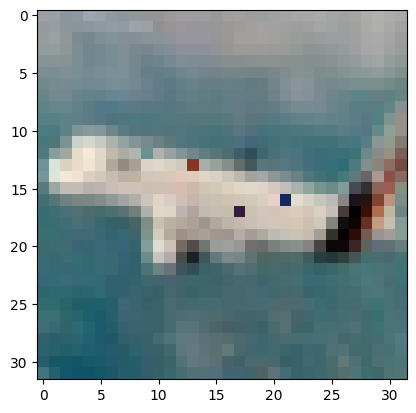

Actual: 0, Predicted: 8

All Convolution - image 4206 - pixel count 4


/content/OnePixelAttackCIFAR10/DifferentialEvolution.py:585: RuntimeWarning: divide by zero encountered in scalar divide
  convergence=self.tol / convergence) is True):


KeyboardInterrupt: 

In [31]:
# Load CIFAR-10 data set
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Results CSV path
csv_path = "resultsCIFAR10.csv"

# Create an instance of the Attack class
attack_instance = Attack(
    x_test=x_test,
    y_test=y_test,
    models=models,
    csv_path=csv_path,
    correct_imgs=correct_imgs,
    maxiter=75,
    popsize=400,
    verbose=True
)

final_results = attack_instance.attack_all(
    samples=10,
    pixels=(4,5),
    targeted=False
)